In [2]:
library(tidyverse)
library(readxl)
library(lubridate)
library(forecast)

── Attaching packages ─────────────────────────────────────── tidyverse 1.2.1 ──
✔ ggplot2 3.1.0     ✔ purrr   0.2.5
✔ tibble  1.4.2     ✔ dplyr   0.7.8
✔ tidyr   0.8.2     ✔ stringr 1.3.1
✔ readr   1.3.1     ✔ forcats 0.3.0
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Attaching package: ‘lubridate’

The following object is masked from ‘package:base’:

    date


Attaching package: ‘forecast’

The following object is masked from ‘package:ggplot2’:

    autolayer



# Carga de precios

In [3]:
df_precios<-list.files("../Colombian_Energy_Forecasting/files/Precios/",pattern = "*.csv",full.names = TRUE)%>%map_df(~read_csv(.,col_names = TRUE,cols(
  Fecha = col_date(format = ""),
  H0 = col_double(),
  H1 = col_double(),
  H2 = col_double(),
  H3 = col_double(),
  H4 = col_double(),
  H5 = col_double(),
  H6 = col_double(),
  H7 = col_double(),
  H8 = col_double(),
  H9 = col_double(),
  H10 = col_double(),
  H11 = col_double(),
  H12 = col_double(),
  H13 = col_double(),
  H14 = col_double(),
  H15 = col_double(),
  H16 = col_double(),
  H17 = col_double(),
  H18 = col_double(),
  H19 = col_double(),
  H20 = col_double(),
  H21 = col_double(),
  H22 = col_double(),
  H23 = col_double()
)))

In [4]:
#Cargar informacion de IPC
ipc<-read_excel('IPC_Mensual.xlsx')

readxl works best with a newer version of the tibble package.
You currently have tibble v1.4.2.
Falling back to column name repair from tibble <= v1.4.2.
Message displays once per session.


In [5]:
#Sacar el promedio de los dias
prom<-(df_precios$H0+df_precios$H1+df_precios$H2+df_precios$H3+df_precios$H4+df_precios$H5+df_precios$H6+df_precios$H7+df_precios$H8+df_precios$H9+df_precios$H10+df_precios$H11+df_precios$H12+df_precios$H13+df_precios$H14+df_precios$H15+df_precios$H16+df_precios$H17+df_precios$H18+df_precios$H19+df_precios$H20+df_precios$H21+df_precios$H22+df_precios$H23)/24

#Combinar el prommedio con el data frame
df_precios<-cbind(df_precios,promedio=prom)%>%drop_na()


In [6]:
#df_precios%>%mutate(Ano_Mes=as.character(paste0(year(Fecha),'-',if_else(month(Fecha)>=10,as.character(month(Fecha)),paste0(as.character(paste0('0',month(Fecha))))))))

In [7]:
# #Sacar el promedio de los dias
# prom<-(df_precios$H0+df_precios$H1+df_precios$H2+df_precios$H3+df_precios$H4+df_precios$H5+df_precios$H6+df_precios$H7+df_precios$H8+df_precios$H9+df_precios$H10+df_precios$H11+df_precios$H12+df_precios$H13+df_precios$H14+df_precios$H15+df_precios$H16+df_precios$H17+df_precios$H18+df_precios$H19+df_precios$H20+df_precios$H21+df_precios$H22+df_precios$H23)/24

# #Combinar el prommedio con el data frame
# df_precios<-cbind(df_precios,promedio=prom)

#Precios mensuales
df_mes<-df_precios%>%mutate(Ano_Mes=as.character(paste0(year(Fecha),'-',if_else(month(Fecha)>=10,as.character(month(Fecha)),paste0(as.character(paste0('0',month(Fecha))))))))
df_mes<-df_mes%>%select(Ano_Mes,everything())
df_mes<-df_mes%>%mutate(Ano=year(Fecha))
df_mes<-df_mes%>%mutate(Mes=month(Fecha))

In [8]:
df_mes<-df_mes%>%arrange(Ano,Mes)%>%group_by(Ano,Mes,Ano_Mes)%>%summarise(promedio_mes=mean(promedio))

In [9]:
#Precios constantesa diciembre de 2008
df_constantes<-left_join(df_mes,ipc,by = 'Ano_Mes')%>%drop_na()%>%mutate(precios_constantes=promedio_mes/(IPC/100))%>%select(Ano,Mes,Ano_Mes,precios_constantes,promedio_mes,IPC)

In [10]:
df_constantes<-df_constantes%>%filter(Ano>=2000)

# Aportes mensuales en energía

In [11]:
df_aportes<-list.files('Aportes/',pattern = '*.xlsx',full.names = T)%>%lapply(read_xlsx,skip=2)%>%bind_rows()

In [12]:
df_aportes<-bind_rows(df_aportes,list.files('Aportes/',pattern = '*1[7-9].xls',full.names = T)%>%lapply(read_xls,skip=2)%>%bind_rows())

In [13]:
# Quitar espacios y caracteres problema
colnames(df_aportes)<-gsub(" ","_",colnames(df_aportes))
colnames(df_aportes)<-gsub("ñ","n",colnames(df_aportes))
colnames(df_aportes)<-gsub("/","_",colnames(df_aportes))

# Paso intermedio -------------> quitar tildes
unwanted_array<-list('á'='a','é'='e','í'='i','ó'='o','ñ'='n')

colnames(df_aportes)<-chartr(paste(names(unwanted_array), collapse=''),
         paste(unwanted_array, collapse=''),
         colnames(df_aportes))

In [14]:
df_aportes<-df_aportes%>%mutate(Mes_num=ifelse(Mes=='ENERO','01',ifelse(Mes=='FEBRERO','02',ifelse(Mes=='MARZO','03',ifelse(Mes=='ABRIL','04',ifelse(Mes=='MAYO','05',ifelse(Mes=='JUNIO','06',ifelse(Mes=='JULIO','07',ifelse(Mes=='AGOSTO','08',ifelse(Mes=='SEPTIEMBRE','09',ifelse(Mes=='OCTUBRE','10',ifelse(Mes=='NOVIEMBRE','11','12'))))))))))))

df_aportes<-df_aportes%>%mutate(Ano_Mes=paste(Ano,Mes_num,sep="-"))

#Revisa que tenga 12 meses por cada ano

###df_aportes%>%select(Ano_Mes,everything())%>%select(Ano_Mes,Ano,Aportes_Energia_kWh)%>%arrange(Ano_Mes,Ano)%>%group_by(Ano_Mes,Ano)%>%summarize(Aportes_Energia_kWh_mes=sum(Aportes_Energia_kWh,na.rm = TRUE))%>%group_by(Ano)%>%count()

#Ahora si sumamos los aportes
df_aportes<-df_aportes%>%select(Ano_Mes,everything())%>%select(Ano_Mes,Aportes_Energia_kWh)%>%arrange(Ano_Mes)%>%group_by(Ano_Mes)%>%summarize(Aportes_Energia_GWh=sum(Aportes_Energia_kWh/1e6,na.rm = TRUE))


In [15]:
df_aportes<-cbind(df_aportes,tidyr::separate(data = df_aportes,col = Ano_Mes,into =c('Ano','Mes'),sep = '-')%>%select(Mes))


In [16]:
df_aportes<-left_join(df_aportes,df_aportes%>%arrange(Mes)%>%group_by(Mes)%>%summarize(mean=mean(Aportes_Energia_GWh),sd=sd(Aportes_Energia_GWh)),by='Mes')

In [17]:
head(df_aportes)
tail(df_aportes)
df_aportes%>%nrow

Ano_Mes,Aportes_Energia_GWh,Mes,mean,sd
2000-01,1900.660,01,2387.357,860.5643
2000-02,1993.636,02,1977.469,571.9035
2000-03,2253.361,03,2921.435,1105.0457
2000-04,2429.651,04,4456.870,1832.5230
2000-05,4817.901,05,6027.007,1735.7382
2000-06,4889.563,06,5812.246,1105.3876


,Ano_Mes,Aportes_Energia_GWh,Mes,mean,sd
228,2018-12,2956.195,12,3587.722,1308.8344
229,2019-01,2176.169,01,2387.357,860.5643
230,2019-02,2084.211,02,1977.469,571.9035
231,2019-03,3153.181,03,2921.435,1105.0457
232,2019-04,5503.107,04,4456.870,1832.5230
233,2019-05,6993.882,05,6027.007,1735.7382


[1] 233

In [18]:
df_aportes<-df_aportes%>%mutate(Aportes_Estandarizados=(Aportes_Energia_GWh-mean)/sd)
df_aportes%>%head

Ano_Mes,Aportes_Energia_GWh,Mes,mean,sd,Aportes_Estandarizados
2000-01,1900.660,01,2387.357,860.5643,-0.56555556
2000-02,1993.636,02,1977.469,571.9035,0.02826836
2000-03,2253.361,03,2921.435,1105.0457,-0.60456759
2000-04,2429.651,04,4456.870,1832.5230,-1.10624476
2000-05,4817.901,05,6027.007,1735.7382,-0.69659476
2000-06,4889.563,06,5812.246,1105.3876,-0.83471448


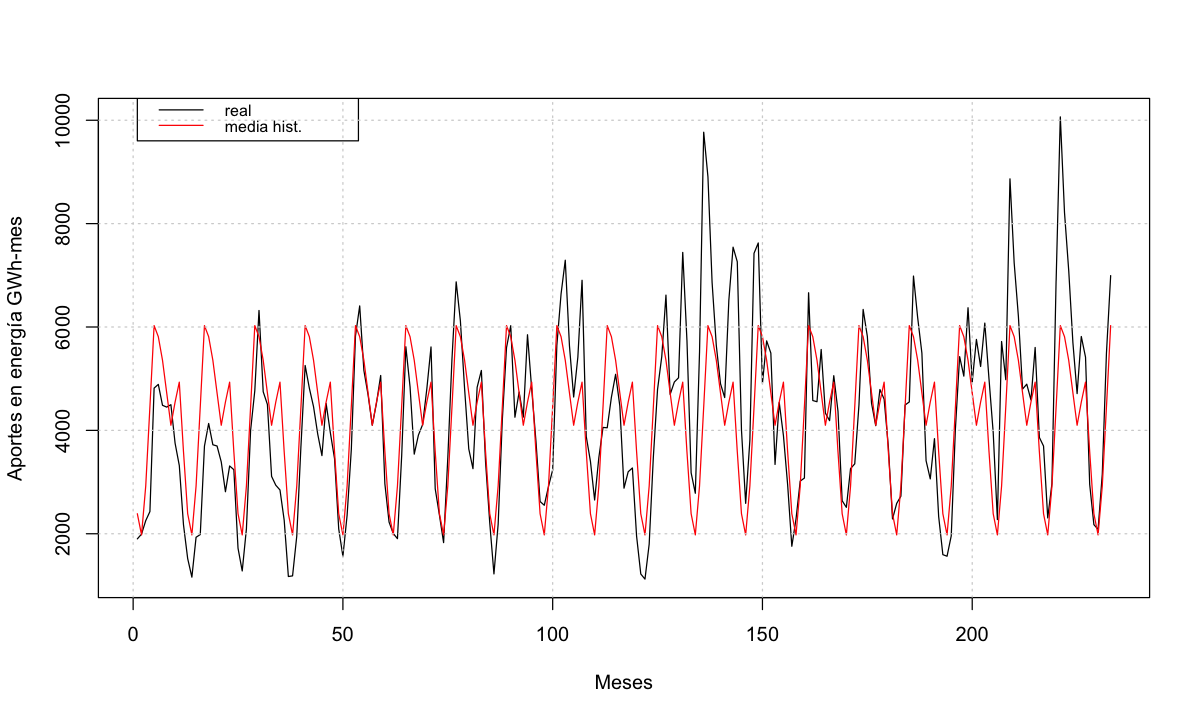

In [19]:
options(repr.plot.width=10, repr.plot.height=6)
plot(df_aportes$Aportes_Energia_GWh,type='l',ylab='Aportes en energía GWh-mes', xlab = 'Meses')
lines(df_aportes$mean,col='red')
legend(x = 1,y = 10500,legend = c('real','media hist.'),col = c('black','red'),lty=c(1,1),cex = 0.8)
grid()

# Reservas mensuales en energía

In [20]:
# Sacar reservas mensuales
df_reservas<-list.files('Reservas/',pattern = '*.xlsx',full.names = T)%>%lapply(read_xlsx,skip=2)%>%bind_rows()

In [21]:
df_reservas<-bind_rows(df_reservas,list.files('Reservas/',pattern = '*1[7-9].xls',full.names = T)%>%lapply(read_xls,skip=2)%>%bind_rows())

In [22]:
# Quitar espacios y caracteres problema
colnames(df_reservas)<-gsub(" ","_",colnames(df_reservas))
colnames(df_reservas)<-gsub("ñ","n",colnames(df_reservas))
colnames(df_reservas)<-gsub("/","_",colnames(df_reservas))



# Paso intermedio -------------> quitar tildes
unwanted_array<-list('á'='a','é'='e','í'='i','ó'='o','ñ'='n','Ú'='U')

colnames(df_reservas)<-chartr(paste(names(unwanted_array), collapse=''),
         paste(unwanted_array, collapse=''),
         colnames(df_reservas))

In [23]:
df_reservas<-df_reservas%>%mutate(Mes_num=ifelse(Mes=='ENERO','01',ifelse(Mes=='FEBRERO','02',ifelse(Mes=='MARZO','03',ifelse(Mes=='ABRIL','04',ifelse(Mes=='MAYO','05',ifelse(Mes=='JUNIO','06',ifelse(Mes=='JULIO','07',ifelse(Mes=='AGOSTO','08',ifelse(Mes=='SEPTIEMBRE','09',ifelse(Mes=='OCTUBRE','10',ifelse(Mes=='NOVIEMBRE','11','12'))))))))))))
df_reservas<-df_reservas%>%mutate(Ano_Mes=paste(Ano,Mes_num,sep="-"))

#Revisa que tenga 12 meses por cada ano

###df_reservas%>%select(Ano_Mes,everything())%>%select(Ano_Mes,Ano,Volumen_Util_Diario_Energia_kWh)%>%arrange(Ano_Mes,Ano)%>%group_by(Ano_Mes,Ano)%>%summarize(Volumen_Util_Diario_Energia_kWh_mes=sum(Volumen_Util_Diario_Energia_kWh,na.rm = TRUE))%>%group_by(Ano)%>%count()

#Ahora si sumamos los reservas
df_reservas<-df_reservas%>%select(Ano_Mes,everything())%>%select(Ano_Mes,Volumen_Util_Diario_Energia_kWh)%>%arrange(Ano_Mes)%>%group_by(Ano_Mes)%>%summarize(Volumen_Util_Diario_Energia_GWh=sum(Volumen_Util_Diario_Energia_kWh/1e6,na.rm = TRUE))

In [24]:
df_reservas<-cbind(df_reservas,tidyr::separate(data = df_reservas,col = Ano_Mes,into =c('Ano','Mes'),sep = '-')%>%select(Mes))

In [25]:
df_reservas<-left_join(df_reservas,df_reservas%>%arrange(Mes)%>%group_by(Mes)%>%summarize(mean=mean(Volumen_Util_Diario_Energia_GWh),sd=sd(Volumen_Util_Diario_Energia_GWh)),by='Mes')

In [26]:
df_reservas<-df_reservas%>%mutate(Reservas_Estandarizadas=(Volumen_Util_Diario_Energia_GWh-mean)/sd)

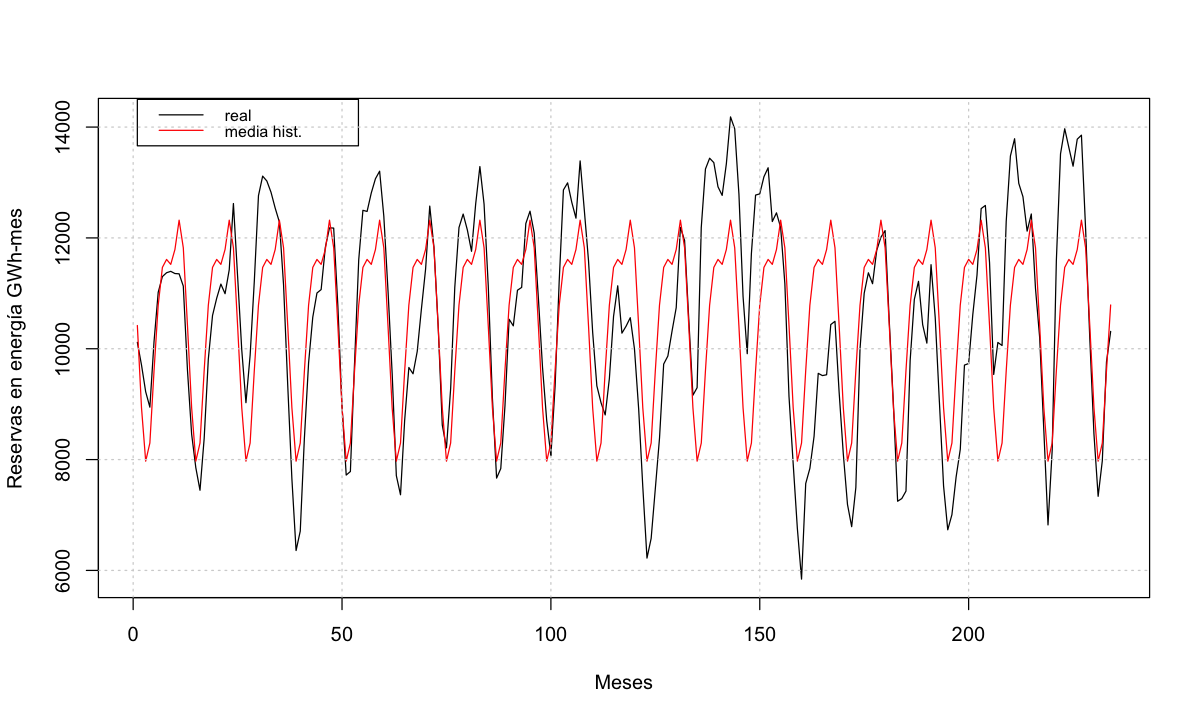

In [27]:
options(repr.plot.width=10, repr.plot.height=6)
plot(df_reservas$Volumen_Util_Diario_Energia_GWh,type='l',ylab='Reservas en energía GWh-mes', xlab = 'Meses')
lines(df_reservas$mean,col='red')
legend(x = 1,y = 14500,legend = c('real','media hist.'),col = c('black','red'),lty=c(1,1),cex = 0.8)
grid()

# Demanda mensual del SIN

In [28]:
# Demanda mensual del SIN
df_demanda<-list.files('Demanda/',pattern = '*.xlsx',full.names = T)%>%lapply(read_xlsx,skip=2)%>%bind_rows()

In [29]:
df_demanda<-bind_rows(df_demanda,list.files('demanda/',pattern = '*1[1-2].xls',full.names = T)%>%lapply(read_xls,skip=2)%>%bind_rows())
df_demanda<-bind_rows(df_demanda,list.files('demanda/',pattern = '*1[7-9].xls',full.names = T)%>%lapply(read_xls,skip=2)%>%bind_rows())


In [30]:
# Quitar espacios y caracteres problema
colnames(df_demanda)<-gsub(" ","_",colnames(df_demanda))
colnames(df_demanda)<-gsub("ñ","n",colnames(df_demanda))
colnames(df_demanda)<-gsub("/","_",colnames(df_demanda))



# Paso intermedio -------------> quitar tildes
unwanted_array<-list('á'='a','é'='e','í'='i','ó'='o','ñ'='n','Ú'='U')

colnames(df_demanda)<-chartr(paste(names(unwanted_array), collapse=''),
         paste(unwanted_array, collapse=''),
         colnames(df_demanda))

In [31]:
df_demanda$Fecha<-as.Date(df_demanda$Fecha)

In [32]:
df_demanda%>%head()
df_demanda%>%tail()

Fecha,Demanda_Energia_SIN_kWh,Generacion_kWh,Demanda_No_Atendida_kWh,Exportaciones_kWh,Importaciones_kWh
2000-01-01,88141870,87924260,8690,NA,208920
2000-01-02,89124367,88753707,96580,NA,274080
2000-01-03,106186255,105883785,32890,NA,269580
2000-01-04,109554603,109207003,62480,NA,285120
2000-01-05,109348213,109069263,5770,NA,273180
2000-01-06,110607542,110268342,99980,NA,239220


Fecha,Demanda_Energia_SIN_kWh,Generacion_kWh,Demanda_No_Atendida_kWh,Exportaciones_kWh,Importaciones_kWh
2019-06-02,170998374,164485555,544430,1678.13,5970067
2019-06-03,176060249,173404910,625020,2873.29,2033192
2019-06-04,201506626,199681880,24440,4395.12,1804702
2019-06-05,204921949,202190837,9920,204.18,2721395
2019-06-06,201349465,196823419,103180,4057.61,4426924
2019-06-07,106800,NA,106800,NA,NA


In [33]:
df_demanda<-df_demanda%>%mutate(Ano_Mes=paste(year(Fecha),ifelse(month(Fecha)/10>=1,month(Fecha),paste0('0',month(Fecha))),sep = '-'))%>%select(Fecha,Ano_Mes,Demanda_Energia_SIN_kWh)

In [34]:
df_demanda<-df_demanda%>%group_by(Ano_Mes)%>%summarize(Demanda_Energia_SIN_GWh=sum(Demanda_Energia_SIN_kWh/1e6))

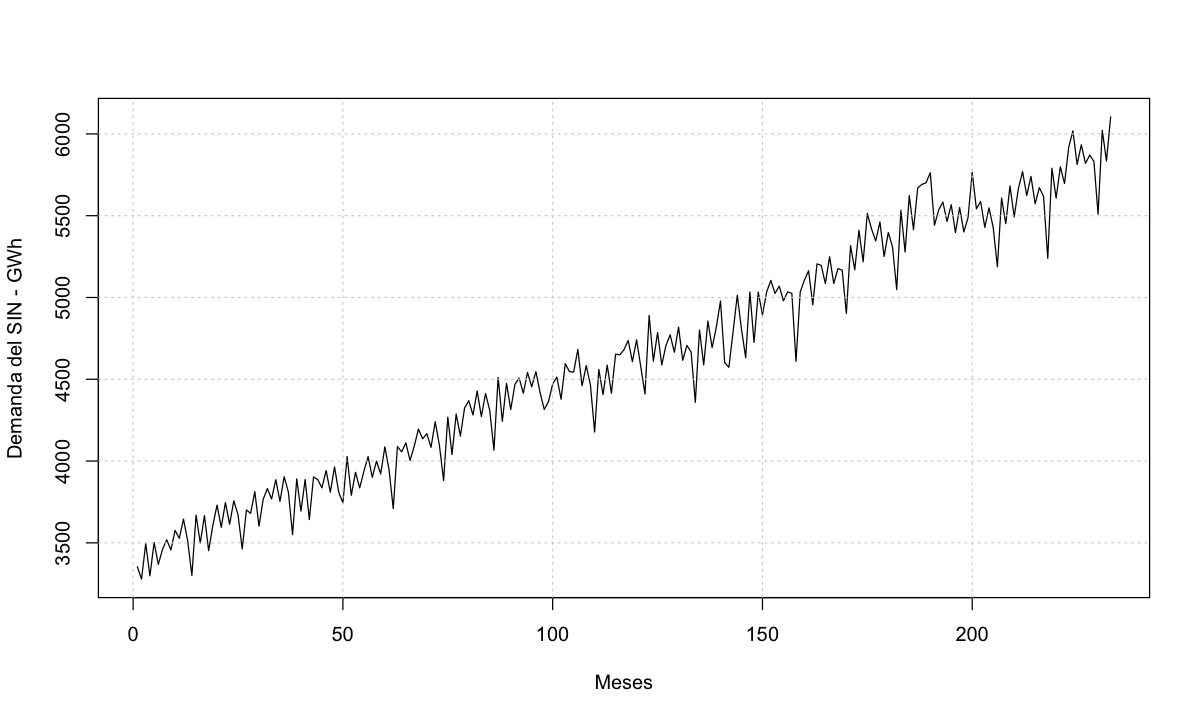

In [35]:
options(repr.plot.width=10, repr.plot.height=6)
plot(df_demanda$Demanda_Energia_SIN_GWh[-length(df_demanda$Demanda_Energia_SIN_GWh)],type='l',ylab = 'Demanda del SIN - GWh', xlab = 'Meses')
grid()

# CEN

In [36]:
# Demanda mensual del SIN
df_cen1<-list.files('CEN/',pattern = '*.xlsx',full.names = T)[1:2]%>%lapply(read_xlsx,skip=3)%>%bind_rows()

df_cen2<-list.files('CEN/',pattern = '*.xlsx',full.names = T)[3:9]%>%lapply(read_xlsx,skip=2)%>%bind_rows()

df_cen3<-list.files('CEN/',pattern = '*.xlsx',full.names = T)[10:11]%>%lapply(read_xlsx,skip=3)%>%bind_rows()
df_cen3<-df_cen3[,!apply(is.na(df_cen3),2,all)]
df_cen4<-list.files('CEN/',pattern = '*.xlsx',full.names = T)[12:16]%>%lapply(read_xlsx,skip=3)%>%bind_rows()
df_cen4<-df_cen4[,!apply(is.na(df_cen4),2,all)]
df_cen5<-list.files('CEN/',pattern = '*.xlsx',full.names = T)[17:20]%>%lapply(read_xlsx,skip=2)%>%bind_rows()
df_cen5<-df_cen5[,!apply(is.na(df_cen5),2,all)]
df_cen6<-list.files('CEN/',pattern = '1[8-9]SEM[1-2].xls',full.names = T)%>%lapply(read_xls,skip=2)%>%bind_rows()
df_cen6<-df_cen6[,!apply(is.na(df_cen6),2,all)]

In [37]:
df_cen<-rbind(df_cen1,df_cen2[,1:7],
               df_cen3%>%select(-one_of(c('Es Menor','Es Autogenerador'))),
               df_cen4%>%select(-one_of(c('Es Menor','Es Autogenerador'))),
               df_cen5%>%select(-one_of(c('Es Menor','Es Autogenerador'))),
               df_cen6%>%select(-one_of(c('Es Menor','Es Autogenerador'))))
df_cen$Fecha<-as.Date(df_cen$Fecha,format = '%Y-%m-%d')
colnames(df_cen)<-c('Fecha','Recurso','Codigo_Agente','Tipo_Generacion','Combustible_defecto','Tipo_Despacho','CEN')
df_cen$CEN_GW<-df_cen$CEN/1e6

In [38]:
str(df_cen)

Classes ‘tbl_df’, ‘tbl’ and 'data.frame':	1069565 obs. of  8 variables:
 $ Fecha              : Date, format: "2000-01-01" "2000-01-01" ...
 $ Recurso            : chr  "ALTO ANCHICAYA" "AMERICA" "ASNAZU" "AYURA" ...
 $ Codigo_Agente      : chr  "EPSG" "EPMG" "CDLG" "EPMG" ...
 $ Tipo_Generacion    : chr  "HIDRAULICA" "HIDRAULICA" "HIDRAULICA" "HIDRAULICA" ...
 $ Combustible_defecto: chr  "AGUA" "AGUA" "AGUA" "AGUA" ...
 $ Tipo_Despacho      : chr  "DESPACHADO CENTRALMENTE" "NO DESPACHADO CENTRALMENTE" "NO DESPACHADO CENTRALMENTE" "NO DESPACHADO CENTRALMENTE" ...
 $ CEN                : num  355000 410 450 18000 74000 12000 12000 63000 30000 20000 ...
 $ CEN_GW             : num  0.355 0.00041 0.00045 0.018 0.074 0.012 0.012 0.063 0.03 0.02 ...


In [39]:
df_cen%>%filter(Tipo_Generacion%in%c('TERMICA','HIDRAULICA'))%>%arrange(Fecha,Tipo_Generacion)%>%str

Classes ‘tbl_df’, ‘tbl’ and 'data.frame':	1017811 obs. of  8 variables:
 $ Fecha              : Date, format: "2000-01-01" "2000-01-01" ...
 $ Recurso            : chr  "ALTO ANCHICAYA" "AMERICA" "ASNAZU" "AYURA" ...
 $ Codigo_Agente      : chr  "EPSG" "EPMG" "CDLG" "EPMG" ...
 $ Tipo_Generacion    : chr  "HIDRAULICA" "HIDRAULICA" "HIDRAULICA" "HIDRAULICA" ...
 $ Combustible_defecto: chr  "AGUA" "AGUA" "AGUA" "AGUA" ...
 $ Tipo_Despacho      : chr  "DESPACHADO CENTRALMENTE" "NO DESPACHADO CENTRALMENTE" "NO DESPACHADO CENTRALMENTE" "NO DESPACHADO CENTRALMENTE" ...
 $ CEN                : num  355000 410 450 18000 74000 600 350 3400 540000 200 ...
 $ CEN_GW             : num  0.355 0.00041 0.00045 0.018 0.074 0.0006 0.00035 0.0034 0.54 0.0002 ...


In [40]:
ultimo_mes<-as.Date(now())-day(as.Date(now()))

In [41]:
ultima_fecha<-as.Date(ultimo_mes-days_in_month(month(as.Date(ultimo_mes)))+1)

In [42]:
df_cen_final<-df_cen[df_cen$Fecha%in%seq.Date(from = as.Date('2000-01-01'),to = ultima_fecha,by = 'month'),]%>%
                filter(Tipo_Generacion%in%c('TERMICA','HIDRAULICA'))%>%
                group_by(Fecha,Tipo_Generacion)%>%
                summarise(Total=sum(CEN_GW))

In [43]:
# df_cen_final%>%mutate(Ano_Mes=as.character(paste0(year(Fecha),'-',if_else(month(Fecha)>=10,as.character(month(Fecha)),paste0(as.character(paste0('0',month(Fecha))))))))%>%filter(Tipo_Generacion=='HIDRAULICA')


# Union de df

In [44]:
left_join(df_constantes%>%select(Ano_Mes,precios_constantes),df_aportes, by = 'Ano_Mes')%>%head

Adding missing grouping variables: `Ano`, `Mes`


Ano,Mes.x,Ano_Mes,precios_constantes,Aportes_Energia_GWh,Mes.y,mean,sd,Aportes_Estandarizados
2000,1,2000-01,63.70022,1900.660,01,2387.357,860.5643,-0.56555556
2000,2,2000-02,68.16305,1993.636,02,1977.469,571.9035,0.02826836
2000,3,2000-03,62.64846,2253.361,03,2921.435,1105.0457,-0.60456759
2000,4,2000-04,73.00825,2429.651,04,4456.870,1832.5230,-1.10624476
2000,5,2000-05,61.14130,4817.901,05,6027.007,1735.7382,-0.69659476
2000,6,2000-06,65.58425,4889.563,06,5812.246,1105.3876,-0.83471448


In [45]:
df1<-left_join(df_constantes%>%select(Ano_Mes,precios_constantes),df_aportes, by = 'Ano_Mes')%>%
        left_join(df_reservas,by = 'Ano_Mes')%>%
        left_join(df_cen_final%>%mutate(Ano_Mes=as.character(paste0(year(Fecha),'-',if_else(month(Fecha)>=10,as.character(month(Fecha)),paste0(as.character(paste0('0',month(Fecha))))))))%>%filter(Tipo_Generacion=='HIDRAULICA'),by='Ano_Mes')

Adding missing grouping variables: `Ano`, `Mes`


In [46]:
head(df1)

Ano,Mes.x,Ano_Mes,precios_constantes,Aportes_Energia_GWh,Mes.y,mean.x,sd.x,Aportes_Estandarizados,Volumen_Util_Diario_Energia_GWh,Mes,mean.y,sd.y,Reservas_Estandarizadas,Fecha,Tipo_Generacion,Total
2000,1,2000-01,63.70022,1900.660,01,2387.357,860.5643,-0.56555556,10115.866,01,10418.906,1018.8277,-0.2974396,2000-01-01,HIDRAULICA,7.89597
2000,2,2000-02,68.16305,1993.636,02,1977.469,571.9035,0.02826836,9705.065,02,8931.573,947.0586,0.8167309,2000-02-01,HIDRAULICA,7.97497
2000,3,2000-03,62.64846,2253.361,03,2921.435,1105.0457,-0.60456759,9222.966,03,7971.466,1191.9835,1.0499306,2000-03-01,HIDRAULICA,7.97497
2000,4,2000-04,73.00825,2429.651,04,4456.870,1832.5230,-1.10624476,8945.684,04,8298.807,1671.8904,0.3869137,2000-04-01,HIDRAULICA,8.05797
2000,5,2000-05,61.14130,4817.901,05,6027.007,1735.7382,-0.69659476,10131.148,05,9605.625,1865.8465,0.2816541,2000-05-01,HIDRAULICA,8.14297
2000,6,2000-06,65.58425,4889.563,06,5812.246,1105.3876,-0.83471448,11020.110,06,10789.601,1787.4070,0.1289627,2000-06-01,HIDRAULICA,8.23427


In [47]:
df1<-df1%>%
    select(Ano_Mes,Ano,precios_constantes,Reservas_Estandarizadas,Aportes_Estandarizados,CEN_H=Total)

Adding missing grouping variables: `Mes.x`


In [48]:
df1<-df1%>%
        left_join(df_cen_final%>%mutate(Ano_Mes=as.character(paste0(year(Fecha),'-',if_else(month(Fecha)>=10,as.character(month(Fecha)),paste0(as.character(paste0('0',month(Fecha))))))))%>%filter(Tipo_Generacion=='TERMICA'),by='Ano_Mes')%>%select(Ano_Mes,precios_constantes,Reservas_Estandarizadas,Aportes_Estandarizados,CEN_H,CEN_T=Total)

Adding missing grouping variables: `Ano`, `Mes.x`


In [49]:
df1<-df1%>%left_join(df_demanda,by='Ano_Mes')

In [50]:
df1%>%head
df1%>%nrow

Ano,Mes.x,Ano_Mes,precios_constantes,Reservas_Estandarizadas,Aportes_Estandarizados,CEN_H,CEN_T,Demanda_Energia_SIN_GWh
2000,1,2000-01,63.70022,-0.2974396,-0.56555556,7.89597,3.897,3354.237
2000,2,2000-02,68.16305,0.8167309,0.02826836,7.97497,3.897,3278.267
2000,3,2000-03,62.64846,1.0499306,-0.60456759,7.97497,3.897,3495.203
2000,4,2000-04,73.00825,0.3869137,-1.10624476,8.05797,3.897,3298.386
2000,5,2000-05,61.14130,0.2816541,-0.69659476,8.14297,3.895,3502.127
2000,6,2000-06,65.58425,0.1289627,-0.83471448,8.23427,4.051,3367.886


[1] 233

In [51]:
length(as.vector(days_in_month(seq.Date(from = as.Date('2000-01-01'),to = ultima_fecha,by = 'month'))))

[1] 233

In [52]:
# df1<-df1%>%mutate(dias_mes=ifelse(Mes.x==1,31,
#                               ifelse(Mes.x==2,28,
#                                      ifelse(Mes.x==3,31,
#                                             ifelse(Mes.x==4,30,
#                                                   ifelse(Mes.x==5,31,
#                                                         ifelse(Mes.x==6,30,
#                                                               ifelse(Mes.x==7,31,
#                                                                     ifelse(Mes.x==8,31,
#                                                                           ifelse(Mes.x==9,30,
#                                                                                 ifelse(Mes.x==10,31,
#                                                                                       ifelse(Mes.x==11,30,
#                                                                                             ifelse(Mes.x==12,31,NA)
#                                                                                             )
#                                                                                       )
#                                                                                 )
#                                                                           )
#                                                                     )
#                                                               )
#                                                         )
#                                                   )
#                                            )
#                                     )
#                              )
#             )

df1$dias_mes <- as.vector(days_in_month(seq.Date(from = as.Date('2000-01-01'),to = ultima_fecha,by = 'month')))

In [53]:
head(df1)

Ano,Mes.x,Ano_Mes,precios_constantes,Reservas_Estandarizadas,Aportes_Estandarizados,CEN_H,CEN_T,Demanda_Energia_SIN_GWh,dias_mes
2000,1,2000-01,63.70022,-0.2974396,-0.56555556,7.89597,3.897,3354.237,31
2000,2,2000-02,68.16305,0.8167309,0.02826836,7.97497,3.897,3278.267,29
2000,3,2000-03,62.64846,1.0499306,-0.60456759,7.97497,3.897,3495.203,31
2000,4,2000-04,73.00825,0.3869137,-1.10624476,8.05797,3.897,3298.386,30
2000,5,2000-05,61.14130,0.2816541,-0.69659476,8.14297,3.895,3502.127,31
2000,6,2000-06,65.58425,0.1289627,-0.83471448,8.23427,4.051,3367.886,30


In [54]:
df1$CEN_H2<-df1$CEN_H*df1$dias_mes*24
df1$CEN_T2<-df1$CEN_T*df1$dias_mes*24

df1$Dem_CEN<-df1$Demanda_Energia_SIN_GWh/(df1$CEN_H2+df1$CEN_T2)
df1$Termica_Hidraulica<-df1$CEN_T2/df1$CEN_H2

In [55]:
df1%>%filter(Ano_Mes=='2005-01')

Ano,Mes.x,Ano_Mes,precios_constantes,Reservas_Estandarizadas,Aportes_Estandarizados,CEN_H,CEN_T,Demanda_Energia_SIN_GWh,dias_mes,CEN_H2,CEN_T2,Dem_CEN,Termica_Hidraulica
2005,1,2005-01,102.3649,0.6237398,-0.1878796,8.94519,4.4389,3946.79,31,6655.221,3302.542,0.3963531,0.4962332


In [56]:
df1[df1$Ano[is.na(df1$Ano)],]

Ano,Mes.x,Ano_Mes,precios_constantes,Reservas_Estandarizadas,Aportes_Estandarizados,CEN_H,CEN_T,Demanda_Energia_SIN_GWh,dias_mes,CEN_H2,CEN_T2,Dem_CEN,Termica_Hidraulica


In [57]:
head(df1)

Ano,Mes.x,Ano_Mes,precios_constantes,Reservas_Estandarizadas,Aportes_Estandarizados,CEN_H,CEN_T,Demanda_Energia_SIN_GWh,dias_mes,CEN_H2,CEN_T2,Dem_CEN,Termica_Hidraulica
2000,1,2000-01,63.70022,-0.2974396,-0.56555556,7.89597,3.897,3354.237,31,5874.602,2899.368,0.3822942,0.4935429
2000,2,2000-02,68.16305,0.8167309,0.02826836,7.97497,3.897,3278.267,29,5550.579,2712.312,0.3967457,0.4886539
2000,3,2000-03,62.64846,1.0499306,-0.60456759,7.97497,3.897,3495.203,31,5933.378,2899.368,0.3957097,0.4886539
2000,4,2000-04,73.00825,0.3869137,-1.10624476,8.05797,3.897,3298.386,30,5801.738,2805.840,0.3831955,0.4836206
2000,5,2000-05,61.14130,0.2816541,-0.69659476,8.14297,3.895,3502.127,31,6058.370,2897.880,0.3910261,0.4783267
2000,6,2000-06,65.58425,0.1289627,-0.83471448,8.23427,4.051,3367.886,30,5928.674,2916.720,0.3807502,0.4919683


In [58]:
df1%>%nrow

[1] 233

In [59]:
# Ind_Termica_Hidraulica_1= lag(df1$Termica_Hidraulica,1),
# Ind_Termica_Hidraulica_2= lag(df1$Termica_Hidraulica,2),
# Ind_Termica_Hidraulica_3= lag(df1$Termica_Hidraulica,3),
# Ind_Termica_Hidraulica_4= lag(df1$Termica_Hidraulica,4),
# Ind_Termica_Hidraulica_5= lag(df1$Termica_Hidraulica,5),
# Ind_Termica_Hidraulica_6= lag(df1$Termica_Hidraulica,6),
# Ind_Termica_Hidraulica_7= lag(df1$Termica_Hidraulica,7),
# Ind_Termica_Hidraulica_8= lag(df1$Termica_Hidraulica,8),
# Ind_Termica_Hidraulica_9= lag(df1$Termica_Hidraulica,9),
# Ind_Termica_Hidraulica_10= lag(df1$Termica_Hidraulica,10),
# Ind_Termica_Hidraulica_11= lag(df1$Termica_Hidraulica,11),
# Ind_Termica_Hidraulica_12= lag(df1$Termica_Hidraulica,12),
# Ind_Termica_Hidraulica_13= lag(df1$Termica_Hidraulica,13),
# Ind_Termica_Hidraulica_14= lag(df1$Termica_Hidraulica,14),
# Ind_Termica_Hidraulica_15= lag(df1$Termica_Hidraulica,15))

In [60]:
# df_final<-data.frame(
#     Ano_Mes=df1$Ano_Mes,
#     pt = df1$precios_constantes,
#     pt_1= lag(df1$precios_constantes,1),
#     pt_2= lag(df1$precios_constantes,2),
# pt_3= lag(df1$precios_constantes,3),
# pt_4= lag(df1$precios_constantes,4),
# pt_5= lag(df1$precios_constantes,5),
# pt_6= lag(df1$precios_constantes,6),
# pt_7= lag(df1$precios_constantes,7),
# pt_8= lag(df1$precios_constantes,8),
# pt_9= lag(df1$precios_constantes,9),
# pt_10= lag(df1$precios_constantes,10),
# pt_11= lag(df1$precios_constantes,11),
# pt_12= lag(df1$precios_constantes,12),
# pt_13= lag(df1$precios_constantes,13),
# pt_14= lag(df1$precios_constantes,14),
# pt_15= lag(df1$precios_constantes,15),


# aportes_1= lag(df1$Aportes_Estandarizados,1),
# aportes_2= lag(df1$Aportes_Estandarizados,2),
# aportes_3= lag(df1$Aportes_Estandarizados,3),
# aportes_4= lag(df1$Aportes_Estandarizados,4),
# aportes_5= lag(df1$Aportes_Estandarizados,5),
# aportes_6= lag(df1$Aportes_Estandarizados,6),
# aportes_7= lag(df1$Aportes_Estandarizados,7),
# aportes_8= lag(df1$Aportes_Estandarizados,8),
# aportes_9= lag(df1$Aportes_Estandarizados,9),
# aportes_10= lag(df1$Aportes_Estandarizados,10),
# aportes_11= lag(df1$Aportes_Estandarizados,11),
# aportes_12= lag(df1$Aportes_Estandarizados,12),
# aportes_13= lag(df1$Aportes_Estandarizados,13),
# aportes_14= lag(df1$Aportes_Estandarizados,14),
# aportes_15= lag(df1$Aportes_Estandarizados,15),


# reservas_1= lag(df1$Reservas_Estandarizadas,1),
# reservas_2= lag(df1$Reservas_Estandarizadas,2),
# reservas_3= lag(df1$Reservas_Estandarizadas,3),
# reservas_4= lag(df1$Reservas_Estandarizadas,4),
# reservas_5= lag(df1$Reservas_Estandarizadas,5),
# reservas_6= lag(df1$Reservas_Estandarizadas,6),
# reservas_7= lag(df1$Reservas_Estandarizadas,7),
# reservas_8= lag(df1$Reservas_Estandarizadas,8),
# reservas_9= lag(df1$Reservas_Estandarizadas,9),
# reservas_10= lag(df1$Reservas_Estandarizadas,10),
# reservas_11= lag(df1$Reservas_Estandarizadas,11),
# reservas_12= lag(df1$Reservas_Estandarizadas,12),
# reservas_13= lag(df1$Reservas_Estandarizadas,13),
# reservas_14= lag(df1$Reservas_Estandarizadas,14),
# reservas_15= lag(df1$Reservas_Estandarizadas,15),

    
# Ind_Dem_CEN_1= lag(df1$Dem_CEN,1),
# Ind_Dem_CEN_2= lag(df1$Dem_CEN,2),
# Ind_Dem_CEN_3= lag(df1$Dem_CEN,3),
# Ind_Dem_CEN_4= lag(df1$Dem_CEN,4),
# Ind_Dem_CEN_5= lag(df1$Dem_CEN,5),
# Ind_Dem_CEN_6= lag(df1$Dem_CEN,6),
# Ind_Dem_CEN_7= lag(df1$Dem_CEN,7),
# Ind_Dem_CEN_8= lag(df1$Dem_CEN,8),
# Ind_Dem_CEN_9= lag(df1$Dem_CEN,9),
# Ind_Dem_CEN_10= lag(df1$Dem_CEN,10),
# Ind_Dem_CEN_11= lag(df1$Dem_CEN,11),
# Ind_Dem_CEN_12= lag(df1$Dem_CEN,12),
# Ind_Dem_CEN_13= lag(df1$Dem_CEN,13),
# Ind_Dem_CEN_14= lag(df1$Dem_CEN,14),
# Ind_Dem_CEN_15= lag(df1$Dem_CEN,15),

    
# Ind_Termica_Hidraulica_1= lag(df1$Termica_Hidraulica,1),
# Ind_Termica_Hidraulica_2= lag(df1$Termica_Hidraulica,2),
# Ind_Termica_Hidraulica_3= lag(df1$Termica_Hidraulica,3),
# Ind_Termica_Hidraulica_4= lag(df1$Termica_Hidraulica,4),
# Ind_Termica_Hidraulica_5= lag(df1$Termica_Hidraulica,5),
# Ind_Termica_Hidraulica_6= lag(df1$Termica_Hidraulica,6),
# Ind_Termica_Hidraulica_7= lag(df1$Termica_Hidraulica,7),
# Ind_Termica_Hidraulica_8= lag(df1$Termica_Hidraulica,8),
# Ind_Termica_Hidraulica_9= lag(df1$Termica_Hidraulica,9),
# Ind_Termica_Hidraulica_10= lag(df1$Termica_Hidraulica,10),
# Ind_Termica_Hidraulica_11= lag(df1$Termica_Hidraulica,11),
# Ind_Termica_Hidraulica_12= lag(df1$Termica_Hidraulica,12),
# Ind_Termica_Hidraulica_13= lag(df1$Termica_Hidraulica,13),
# Ind_Termica_Hidraulica_14= lag(df1$Termica_Hidraulica,14),
# Ind_Termica_Hidraulica_15= lag(df1$Termica_Hidraulica,15)

    

# )
# df_final<-df_final%>%drop_na()

# ONI

In [145]:
oni <- read_excel('./ONI.xlsx')

In [153]:
oni%>%filter(Year==2000)%>%head

Year,Enero,Febrero,Marzo,Abril,Mayo,Junio,Julio,Agosto,Septiembre,Octubre,Noviembre,Diciembre
2000,-1.7,-1.4,-1.1,-0.8,-0.7,-0.6,-0.6,-0.5,-0.5,-0.6,-0.7,-0.7


In [149]:
oni2<-oni%>%filter(Year>=2000)%>%gather('Enero', 'Febrero', 'Marzo','Abril','Mayo','Junio','Julio','Agosto','Septiembre','Octubre','Noviembre','Diciembre',  key= 'mes', value = 'oni')



Year,mes,oni
2000,Abril,-0.8
2000,Agosto,-0.5
2000,Diciembre,-0.7
2000,Enero,-1.7
2000,Febrero,-1.4
2000,Julio,-0.6


In [150]:
oni2$mes2<-ifelse(oni2$mes=='Enero',1,
       ifelse(oni2$mes=='Febrero',2,
             ifelse(oni2$mes=='Marzo',3,
                   ifelse(oni2$mes=='Abril',4,
                         ifelse(oni2$mes=='Mayo',5,
                             ifelse(oni2$mes=='Junio',6,
                                 ifelse(oni2$mes=='Julio',7,
                                       ifelse(oni2$mes=='Agosto',8,
                                             ifelse(oni2$mes=='Septiembre',9,
                                                   ifelse(oni2$mes=='Octubre',10,
                                                         ifelse(oni2$mes=='Noviembre',11,
                                                               ifelse(oni2$mes=='Diciembre',12,NA))))))))))))

In [159]:
oni2<-oni2%>%arrange(Year,mes2)

In [160]:
head(oni2)

Year,mes,oni,mes2,Ano_Mes
2000,Enero,-1.7,1,2000-01
2000,Febrero,-1.4,2,2001-09
2000,Marzo,-1.1,3,2003-05
2000,Abril,-0.8,4,2005-01
2000,Mayo,-0.7,5,2006-09
2000,Junio,-0.6,6,2008-05


In [161]:
oni2$Ano_Mes <- str_sub(seq.Date(from = as.Date('2000-01-01'),to = as.Date('2019-12-01'),by = 'month'),1,7)


In [169]:
oni2$oni[oni2$Ano_Mes=='2019-05']<-0.8

# Modelo Forward

In [61]:
# m_2fitAll<-lm(pt~.,data=df_final%>%select(-one_of('Ano_Mes')))
# m<-(step(lm(pt~1,data=df_final),direction = 'forward',scope = formula(m_2fitAll),trace = 0))



In [62]:
# summary(m)

In [63]:
# plot(df_final$pt,type='l')
# lines(m$fitted.values,col='red')

# Log pt 15 rezagos

In [64]:
# df_final<-data.frame(
#     Ano_Mes=df1$Ano_Mes,
#     pt = log(df1$precios_constantes),
#     pt_1= lag(log(df1$precios_constantes),1),
#     pt_2= lag(log(df1$precios_constantes),2),
# pt_3= lag(log(df1$precios_constantes),3),
# pt_4= lag(log(df1$precios_constantes),4),
# pt_5= lag(log(df1$precios_constantes),5),
# pt_6= lag(log(df1$precios_constantes),6),
# pt_7= lag(log(df1$precios_constantes),7),
# pt_8= lag(log(df1$precios_constantes),8),
# pt_9= lag(log(df1$precios_constantes),9),
# pt_10= lag(log(df1$precios_constantes),10),
# pt_11= lag(log(df1$precios_constantes),11),
# pt_12= lag(log(df1$precios_constantes),12),
# pt_13= lag(log(df1$precios_constantes),13),
# pt_14= lag(log(df1$precios_constantes),14),
# pt_15= lag(log(df1$precios_constantes),15),


# aportes_1= lag(df1$Aportes_Estandarizados,1),
# aportes_2= lag(df1$Aportes_Estandarizados,2),
# aportes_3= lag(df1$Aportes_Estandarizados,3),
# aportes_4= lag(df1$Aportes_Estandarizados,4),
# aportes_5= lag(df1$Aportes_Estandarizados,5),
# aportes_6= lag(df1$Aportes_Estandarizados,6),
# aportes_7= lag(df1$Aportes_Estandarizados,7),
# aportes_8= lag(df1$Aportes_Estandarizados,8),
# aportes_9= lag(df1$Aportes_Estandarizados,9),
# aportes_10= lag(df1$Aportes_Estandarizados,10),
# aportes_11= lag(df1$Aportes_Estandarizados,11),
# aportes_12= lag(df1$Aportes_Estandarizados,12),
# aportes_13= lag(df1$Aportes_Estandarizados,13),
# aportes_14= lag(df1$Aportes_Estandarizados,14),
# aportes_15= lag(df1$Aportes_Estandarizados,15),


# reservas_1= lag(df1$Reservas_Estandarizadas,1),
# reservas_2= lag(df1$Reservas_Estandarizadas,2),
# reservas_3= lag(df1$Reservas_Estandarizadas,3),
# reservas_4= lag(df1$Reservas_Estandarizadas,4),
# reservas_5= lag(df1$Reservas_Estandarizadas,5),
# reservas_6= lag(df1$Reservas_Estandarizadas,6),
# reservas_7= lag(df1$Reservas_Estandarizadas,7),
# reservas_8= lag(df1$Reservas_Estandarizadas,8),
# reservas_9= lag(df1$Reservas_Estandarizadas,9),
# reservas_10= lag(df1$Reservas_Estandarizadas,10),
# reservas_11= lag(df1$Reservas_Estandarizadas,11),
# reservas_12= lag(df1$Reservas_Estandarizadas,12),
# reservas_13= lag(df1$Reservas_Estandarizadas,13),
# reservas_14= lag(df1$Reservas_Estandarizadas,14),
# reservas_15= lag(df1$Reservas_Estandarizadas,15),

    
# Ind_Dem_CEN_1= lag(df1$Dem_CEN,1),
# Ind_Dem_CEN_2= lag(df1$Dem_CEN,2),
# Ind_Dem_CEN_3= lag(df1$Dem_CEN,3),
# Ind_Dem_CEN_4= lag(df1$Dem_CEN,4),
# Ind_Dem_CEN_5= lag(df1$Dem_CEN,5),
# Ind_Dem_CEN_6= lag(df1$Dem_CEN,6),
# Ind_Dem_CEN_7= lag(df1$Dem_CEN,7),
# Ind_Dem_CEN_8= lag(df1$Dem_CEN,8),
# Ind_Dem_CEN_9= lag(df1$Dem_CEN,9),
# Ind_Dem_CEN_10= lag(df1$Dem_CEN,10),
# Ind_Dem_CEN_11= lag(df1$Dem_CEN,11),
# Ind_Dem_CEN_12= lag(df1$Dem_CEN,12),
# Ind_Dem_CEN_13= lag(df1$Dem_CEN,13),
# Ind_Dem_CEN_14= lag(df1$Dem_CEN,14),
# Ind_Dem_CEN_15= lag(df1$Dem_CEN,15),

    
# Ind_Termica_Hidraulica_1= lag(df1$Termica_Hidraulica,1),
# Ind_Termica_Hidraulica_2= lag(df1$Termica_Hidraulica,2),
# Ind_Termica_Hidraulica_3= lag(df1$Termica_Hidraulica,3),
# Ind_Termica_Hidraulica_4= lag(df1$Termica_Hidraulica,4),
# Ind_Termica_Hidraulica_5= lag(df1$Termica_Hidraulica,5),
# Ind_Termica_Hidraulica_6= lag(df1$Termica_Hidraulica,6),
# Ind_Termica_Hidraulica_7= lag(df1$Termica_Hidraulica,7),
# Ind_Termica_Hidraulica_8= lag(df1$Termica_Hidraulica,8),
# Ind_Termica_Hidraulica_9= lag(df1$Termica_Hidraulica,9),
# Ind_Termica_Hidraulica_10= lag(df1$Termica_Hidraulica,10),
# Ind_Termica_Hidraulica_11= lag(df1$Termica_Hidraulica,11),
# Ind_Termica_Hidraulica_12= lag(df1$Termica_Hidraulica,12),
# Ind_Termica_Hidraulica_13= lag(df1$Termica_Hidraulica,13),
# Ind_Termica_Hidraulica_14= lag(df1$Termica_Hidraulica,14),
# Ind_Termica_Hidraulica_15= lag(df1$Termica_Hidraulica,15)

    

# )
# df_final<-df_final%>%drop_na()

In [65]:
# m_2fitAll<-lm(pt~.,data=df_final%>%select(-one_of('Ano_Mes')))
# m<-(step(lm(pt~1,data=df_final),direction = 'forward',scope = formula(m_2fitAll),trace = 0))




In [66]:
# summary(m)
# plot(df_final$pt,type='l')
# lines(m$fitted.values,col='red')

# Modelo solo 6 rezagos - Este fue el elegido

Posteriormente pasaremos a escoger las mejores $\lambda$ de cada variable

In [67]:
df_final<-data.frame(
    Ano_Mes=df1$Ano_Mes,
    pt = log(df1$precios_constantes),
    pt_1= lag(log(df1$precios_constantes),1),
    pt_2= lag(log(df1$precios_constantes),2),
pt_3= lag(log(df1$precios_constantes),3),
pt_4= lag(log(df1$precios_constantes),4),
pt_5= lag(log(df1$precios_constantes),5),
pt_6= lag(log(df1$precios_constantes),6),
# pt_7= lag(log(df1$precios_constantes),7),
# pt_8= lag(log(df1$precios_constantes),8),
# pt_9= lag(log(df1$precios_constantes),9),
# pt_10= lag(log(df1$precios_constantes),10),
# pt_11= lag(log(df1$precios_constantes),11),
# pt_12= lag(log(df1$precios_constantes),12),
# pt_13= lag(log(df1$precios_constantes),13),
# pt_14= lag(log(df1$precios_constantes),14),
# pt_15= lag(log(df1$precios_constantes),15),


aportes_1= lag(df1$Aportes_Estandarizados,1),
aportes_2= lag(df1$Aportes_Estandarizados,2),
aportes_3= lag(df1$Aportes_Estandarizados,3),
aportes_4= lag(df1$Aportes_Estandarizados,4),
aportes_5= lag(df1$Aportes_Estandarizados,5),
aportes_6= lag(df1$Aportes_Estandarizados,6),
# aportes_7= lag(df1$Aportes_Estandarizados,7),
# aportes_8= lag(df1$Aportes_Estandarizados,8),
# aportes_9= lag(df1$Aportes_Estandarizados,9),
# aportes_10= lag(df1$Aportes_Estandarizados,10),
# aportes_11= lag(df1$Aportes_Estandarizados,11),
# aportes_12= lag(df1$Aportes_Estandarizados,12),
# aportes_13= lag(df1$Aportes_Estandarizados,13),
# aportes_14= lag(df1$Aportes_Estandarizados,14),
# aportes_15= lag(df1$Aportes_Estandarizados,15),


reservas_1= lag(df1$Reservas_Estandarizadas,1),
reservas_2= lag(df1$Reservas_Estandarizadas,2),
reservas_3= lag(df1$Reservas_Estandarizadas,3),
reservas_4= lag(df1$Reservas_Estandarizadas,4),
reservas_5= lag(df1$Reservas_Estandarizadas,5),
reservas_6= lag(df1$Reservas_Estandarizadas,6),
# reservas_7= lag(df1$Reservas_Estandarizadas,7),
# reservas_8= lag(df1$Reservas_Estandarizadas,8),
# reservas_9= lag(df1$Reservas_Estandarizadas,9),
# reservas_10= lag(df1$Reservas_Estandarizadas,10),
# reservas_11= lag(df1$Reservas_Estandarizadas,11),
# reservas_12= lag(df1$Reservas_Estandarizadas,12),
# reservas_13= lag(df1$Reservas_Estandarizadas,13),
# reservas_14= lag(df1$Reservas_Estandarizadas,14),
# reservas_15= lag(df1$Reservas_Estandarizadas,15),

    
Ind_Dem_CEN_1= lag(df1$Dem_CEN,1),
Ind_Dem_CEN_2= lag(df1$Dem_CEN,2),
Ind_Dem_CEN_3= lag(df1$Dem_CEN,3),
Ind_Dem_CEN_4= lag(df1$Dem_CEN,4),
Ind_Dem_CEN_5= lag(df1$Dem_CEN,5),
Ind_Dem_CEN_6= lag(df1$Dem_CEN,6),
# Ind_Dem_CEN_7= lag(df1$Dem_CEN,7),
# Ind_Dem_CEN_8= lag(df1$Dem_CEN,8),
# Ind_Dem_CEN_9= lag(df1$Dem_CEN,9),
# Ind_Dem_CEN_10= lag(df1$Dem_CEN,10),
# Ind_Dem_CEN_11= lag(df1$Dem_CEN,11),
# Ind_Dem_CEN_12= lag(df1$Dem_CEN,12),
# Ind_Dem_CEN_13= lag(df1$Dem_CEN,13),
# Ind_Dem_CEN_14= lag(df1$Dem_CEN,14),
# Ind_Dem_CEN_15= lag(df1$Dem_CEN,15),

    
Ind_Termica_Hidraulica_1= lag(df1$Termica_Hidraulica,1),
Ind_Termica_Hidraulica_2= lag(df1$Termica_Hidraulica,2),
Ind_Termica_Hidraulica_3= lag(df1$Termica_Hidraulica,3),
Ind_Termica_Hidraulica_4= lag(df1$Termica_Hidraulica,4),
Ind_Termica_Hidraulica_5= lag(df1$Termica_Hidraulica,5),
Ind_Termica_Hidraulica_6= lag(df1$Termica_Hidraulica,6)
# Ind_Termica_Hidraulica_7= lag(df1$Termica_Hidraulica,7),
# Ind_Termica_Hidraulica_8= lag(df1$Termica_Hidraulica,8),
# Ind_Termica_Hidraulica_9= lag(df1$Termica_Hidraulica,9),
# Ind_Termica_Hidraulica_10= lag(df1$Termica_Hidraulica,10),
# Ind_Termica_Hidraulica_11= lag(df1$Termica_Hidraulica,11),
# Ind_Termica_Hidraulica_12= lag(df1$Termica_Hidraulica,12),
# Ind_Termica_Hidraulica_13= lag(df1$Termica_Hidraulica,13),
# Ind_Termica_Hidraulica_14= lag(df1$Termica_Hidraulica,14),
# Ind_Termica_Hidraulica_15= lag(df1$Termica_Hidraulica,15)

    

)
df_final<-df_final%>%drop_na()

In [68]:
m_2fitAll<-lm(pt~.,data=df_final%>%select(-one_of('Ano_Mes')))
m<-(step(lm(pt~1,data=df_final),direction = 'forward',scope = formula(m_2fitAll),trace = 0,extractAIC=TRUE))






Call:
lm(formula = pt ~ pt_1 + Ind_Dem_CEN_3 + aportes_1 + Ind_Termica_Hidraulica_6, 
    data = df_final)

Residuals:
     Min       1Q   Median       3Q      Max 
-0.74672 -0.15194 -0.00079  0.11801  1.00298 

Coefficients:
                         Estimate Std. Error t value Pr(>|t|)    
(Intercept)               0.87312    0.49744   1.755 0.080600 .  
pt_1                      0.68969    0.04817  14.318  < 2e-16 ***
Ind_Dem_CEN_3             2.41040    0.63785   3.779 0.000202 ***
aportes_1                -0.09395    0.02395  -3.922 0.000117 ***
Ind_Termica_Hidraulica_6 -1.07609    0.67925  -1.584 0.114567    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.2411 on 222 degrees of freedom
Multiple R-squared:  0.7583,	Adjusted R-squared:  0.754 
F-statistic: 174.2 on 4 and 222 DF,  p-value: < 2.2e-16


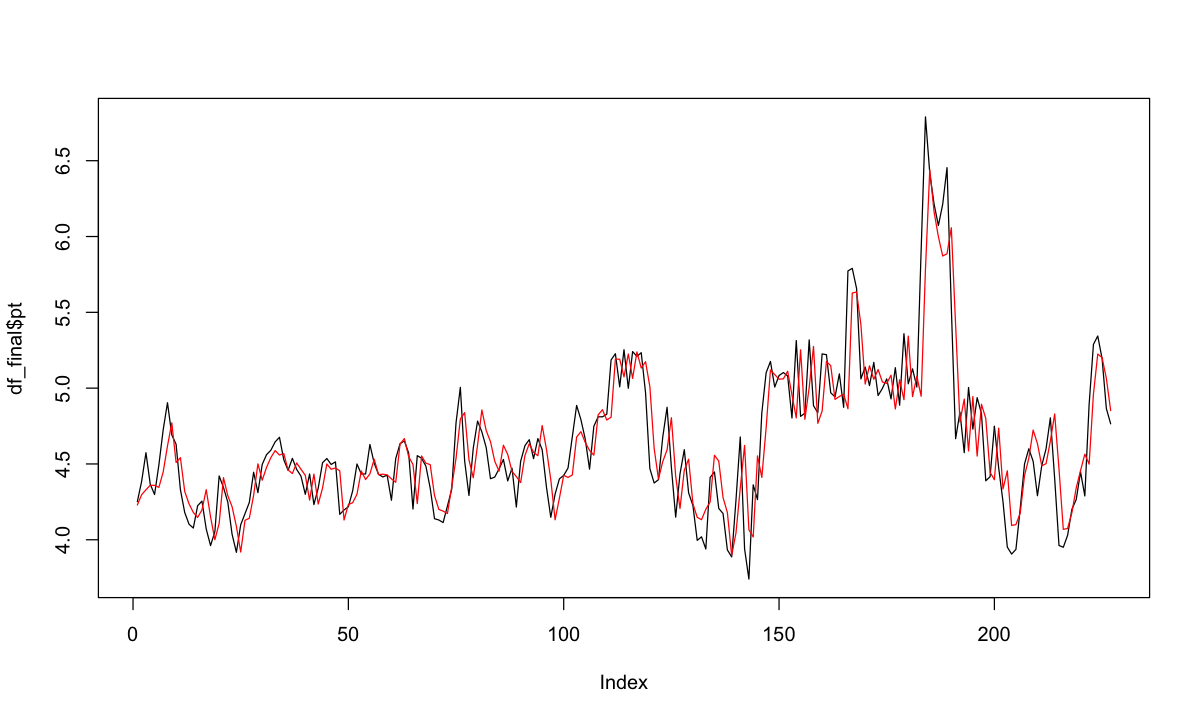

In [69]:
summary(m)
plot(df_final$pt,type='l')
lines(m$fitted.values,col='red')

# Funcion general para buscar transformaciones de variables

In [70]:
# data.frame(variable=colnames(df_conversion[,-1]),adicion =rep(0,5))

#     df_conversion<-df1[,c(3,4,5,6,13,14)]
    
    

#     df_incremento<-data.frame(variable=colnames(df_conversion[,-1]),adicion =rep(NA,5))
    
#     for(i in seq(2, ncol(df_conversion))){
#         incremento<-0
#         parada<-0
#         while(parada==0){
#             if(any(is.nan(BoxCox((unlist(unname(df_conversion[,i]))),0)))){
#                 incremento<-incremento+0.1
#                 df_conversion[,i]<-df_conversion[,i]+incremento
#             } else{
                
#                 df_incremento$adicion[df_incremento$variable==colnames(df_conversion[,i])]<-incremento
                
#                 print(paste0(colnames(df_conversion[,i]), ' paro en ', incremento))
#                 parada <- 1
                
                
#             }
#         }
#     }

In [71]:
crear_matriz<-function(df=df1,lambda_pt=0,lambda_aportes=1,lambda_reservas=1,lambda_Dem_CEN=1,lambda_Term_Hidro=1){
    
    df_conversion<-df[,c(3,4,5,6,13,14)]
    data.frame(variable=colnames(df_conversion[,-1]),adicion =rep(0,5))





    df_incremento<-data.frame(variable=colnames(df_conversion[,-1]),adicion =rep(NA,5))

    for(i in seq(2, ncol(df_conversion))){
        incremento<-0
        parada<-0
        while(parada==0){
            if(any(is.nan(BoxCox((unlist(unname(df_conversion[,i]))),0)))){
                incremento<-incremento+0.1
                df_conversion[,i]<-df_conversion[,i]+incremento
            } else{
                
                df_incremento$adicion[df_incremento$variable==colnames(df_conversion[,i])]<-incremento
                parada <- 1


            }
        }
    }    
    
    write_csv(df_incremento,'./Incrementos/incrementos.csv')
    
    df_final<-data.frame()
    df_final<-data.frame(    
        Ano_Mes=df_conversion$Ano_Mes,
        pt = BoxCox(((df_conversion$precios_constantes+df_incremento$adicion[df_incremento$variable=='precios_constantes'])+df_incremento$adicion[df_incremento$variable=='precios_constantes']),lambda_pt),

        pt_1= lag(BoxCox((df_conversion$precios_constantes+df_incremento$adicion[df_incremento$variable=='precios_constantes']),lambda_pt),1),
        pt_2= lag(BoxCox((df_conversion$precios_constantes+df_incremento$adicion[df_incremento$variable=='precios_constantes']),lambda_pt),2),
        pt_3= lag(BoxCox((df_conversion$precios_constantes+df_incremento$adicion[df_incremento$variable=='precios_constantes']),lambda_pt),3),
        pt_4= lag(BoxCox((df_conversion$precios_constantes+df_incremento$adicion[df_incremento$variable=='precios_constantes']),lambda_pt),4),
        pt_5= lag(BoxCox((df_conversion$precios_constantes+df_incremento$adicion[df_incremento$variable=='precios_constantes']),lambda_pt),5),
        pt_6= lag(BoxCox((df_conversion$precios_constantes+df_incremento$adicion[df_incremento$variable=='precios_constantes']),lambda_pt),6),
        # pt_7= lag(log(df1$precios_constantes),7),
        # pt_8= lag(log(df1$precios_constantes),8),
        # pt_9= lag(log(df1$precios_constantes),9),
        # pt_10= lag(log(df1$precios_constantes),10),
        # pt_11= lag(log(df1$precios_constantes),11),
        # pt_12= lag(log(df1$precios_constantes),12),
        # pt_13= lag(log(df1$precios_constantes),13),
        # pt_14= lag(log(df1$precios_constantes),14),
        # pt_15= lag(log(df1$precios_constantes),15),


        aportes_1= lag(BoxCox((df_conversion$Aportes_Estandarizados+df_incremento$adicion[df_incremento$variable=='Aportes_Estandarizados']),lambda_aportes),1),
        aportes_2= lag(BoxCox((df_conversion$Aportes_Estandarizados+df_incremento$adicion[df_incremento$variable=='Aportes_Estandarizados']),lambda_aportes),2),
        aportes_3= lag(BoxCox((df_conversion$Aportes_Estandarizados+df_incremento$adicion[df_incremento$variable=='Aportes_Estandarizados']),lambda_aportes),3),
        aportes_4= lag(BoxCox((df_conversion$Aportes_Estandarizados+df_incremento$adicion[df_incremento$variable=='Aportes_Estandarizados']),lambda_aportes),4),
        aportes_5= lag(BoxCox((df_conversion$Aportes_Estandarizados+df_incremento$adicion[df_incremento$variable=='Aportes_Estandarizados']),lambda_aportes),5),
        aportes_6= lag(BoxCox((df_conversion$Aportes_Estandarizados+df_incremento$adicion[df_incremento$variable=='Aportes_Estandarizados']),lambda_aportes),6),
        # aportes_7= lag(BoxCox(df1$Aportes_Estandarizados,lambda_aportes),,7),
        # aportes_8= lag(BoxCox(df1$Aportes_Estandarizados,lambda_aportes),,8),
        # aportes_9= lag(BoxCox(df1$Aportes_Estandarizados,lambda_aportes),,9),
        # aportes_10= lag(BoxCox(df1$Aportes_Estandarizados,lambda_aportes),,10),
        # aportes_11= lag(BoxCox(df1$Aportes_Estandarizados,lambda_aportes),,11),
        # aportes_12= lag(BoxCox(df1$Aportes_Estandarizados,lambda_aportes),,12),
        # aportes_13= lag(BoxCox(df1$Aportes_Estandarizados,lambda_aportes),,13),
        # aportes_14= lag(BoxCox(df1$Aportes_Estandarizados,lambda_aportes),,14),
        # aportes_15= lag(BoxCox(df1$Aportes_Estandarizados,lambda_aportes),,15),


        reservas_1= lag(BoxCox((df_conversion$Reservas_Estandarizadas+df_incremento$adicion[df_incremento$variable=='Reservas_Estandarizadas']),lambda_reservas),1),
        reservas_2= lag(BoxCox((df_conversion$Reservas_Estandarizadas+df_incremento$adicion[df_incremento$variable=='Reservas_Estandarizadas']),lambda_reservas),2),
        reservas_3= lag(BoxCox((df_conversion$Reservas_Estandarizadas+df_incremento$adicion[df_incremento$variable=='Reservas_Estandarizadas']),lambda_reservas),3),
        reservas_4= lag(BoxCox((df_conversion$Reservas_Estandarizadas+df_incremento$adicion[df_incremento$variable=='Reservas_Estandarizadas']),lambda_reservas),4),
        reservas_5= lag(BoxCox((df_conversion$Reservas_Estandarizadas+df_incremento$adicion[df_incremento$variable=='Reservas_Estandarizadas']),lambda_reservas),5),
        reservas_6= lag(BoxCox((df_conversion$Reservas_Estandarizadas+df_incremento$adicion[df_incremento$variable=='Reservas_Estandarizadas']),lambda_reservas),6),
        # reservas_7= lag(BoxCox(df1$Reservas_Estandarizadas,lambda_reservas),7),
        # reservas_8= lag(BoxCox(df1$Reservas_Estandarizadas,lambda_reservas),8),
        # reservas_9= lag(BoxCox(df1$Reservas_Estandarizadas,lambda_reservas),9),
        # reservas_10= lag(BoxCox(df1$Reservas_Estandarizadas,lambda_reservas),10),
        # reservas_11= lag(BoxCox(df1$Reservas_Estandarizadas,lambda_reservas),11),
        # reservas_12= lag(BoxCox(df1$Reservas_Estandarizadas,lambda_reservas),12),
        # reservas_13= lag(BoxCox(df1$Reservas_Estandarizadas,lambda_reservas),13),
        # reservas_14= lag(BoxCox(df1$Reservas_Estandarizadas,lambda_reservas),14),
        # reservas_15= lag(BoxCox(df1$Reservas_Estandarizadas,lambda_reservas),15),


        Ind_Dem_CEN_1= lag(BoxCox((df_conversion$Dem_CEN+df_incremento$adicion[df_incremento$variable=='Dem_CEN']),lambda_Dem_CEN),1),
        Ind_Dem_CEN_2= lag(BoxCox((df_conversion$Dem_CEN+df_incremento$adicion[df_incremento$variable=='Dem_CEN']),lambda_Dem_CEN),2),
        Ind_Dem_CEN_3= lag(BoxCox((df_conversion$Dem_CEN+df_incremento$adicion[df_incremento$variable=='Dem_CEN']),lambda_Dem_CEN),3),
        Ind_Dem_CEN_4= lag(BoxCox((df_conversion$Dem_CEN+df_incremento$adicion[df_incremento$variable=='Dem_CEN']),lambda_Dem_CEN),4),
        Ind_Dem_CEN_5= lag(BoxCox((df_conversion$Dem_CEN+df_incremento$adicion[df_incremento$variable=='Dem_CEN']),lambda_Dem_CEN),5),
        Ind_Dem_CEN_6= lag(BoxCox((df_conversion$Dem_CEN+df_incremento$adicion[df_incremento$variable=='Dem_CEN']),lambda_Dem_CEN),6),
        # Ind_Dem_CEN_7= lag(BoxCox(df1$Dem_CEN,lambda_Dem_CEN),7),
        # Ind_Dem_CEN_8= lag(BoxCox(df1$Dem_CEN,lambda_Dem_CEN),8),
        # Ind_Dem_CEN_9= lag(BoxCox(df1$Dem_CEN,lambda_Dem_CEN),9),
        # Ind_Dem_CEN_10= lag(BoxCox(df1$Dem_CEN,lambda_Dem_CEN),10),
        # Ind_Dem_CEN_11= lag(BoxCox(df1$Dem_CEN,lambda_Dem_CEN),11),
        # Ind_Dem_CEN_12= lag(BoxCox(df1$Dem_CEN,lambda_Dem_CEN),12),
        # Ind_Dem_CEN_13= lag(BoxCox(df1$Dem_CEN,lambda_Dem_CEN),13),
        # Ind_Dem_CEN_14= lag(BoxCox(df1$Dem_CEN,lambda_Dem_CEN),14),
        # Ind_Dem_CEN_15= lag(BoxCox(df1$Dem_CEN,lambda_Dem_CEN),15),


        Ind_Termica_Hidraulica_1= lag(BoxCox((df_conversion$Termica_Hidraulica+df_incremento$adicion[df_incremento$variable=='Termica_Hidraulica']),lambda_Term_Hidro),1),
        Ind_Termica_Hidraulica_2= lag(BoxCox((df_conversion$Termica_Hidraulica+df_incremento$adicion[df_incremento$variable=='Termica_Hidraulica']),lambda_Term_Hidro),2),
        Ind_Termica_Hidraulica_3= lag(BoxCox((df_conversion$Termica_Hidraulica+df_incremento$adicion[df_incremento$variable=='Termica_Hidraulica']),lambda_Term_Hidro),3),
        Ind_Termica_Hidraulica_4= lag(BoxCox((df_conversion$Termica_Hidraulica+df_incremento$adicion[df_incremento$variable=='Termica_Hidraulica']),lambda_Term_Hidro),4),
        Ind_Termica_Hidraulica_5= lag(BoxCox((df_conversion$Termica_Hidraulica+df_incremento$adicion[df_incremento$variable=='Termica_Hidraulica']),lambda_Term_Hidro),5),
        Ind_Termica_Hidraulica_6= lag(BoxCox((df_conversion$Termica_Hidraulica+df_incremento$adicion[df_incremento$variable=='Termica_Hidraulica']),lambda_Term_Hidro),6)
        # Ind_Termica_Hidraulica_7= lag(BoxCox(df1$Termica_Hidraulica,lambda_Term_Hidro),7),
        # Ind_Termica_Hidraulica_8= lag(BoxCox(df1$Termica_Hidraulica,lambda_Term_Hidro),8),
        # Ind_Termica_Hidraulica_9= lag(BoxCox(df1$Termica_Hidraulica,lambda_Term_Hidro),9),
        # Ind_Termica_Hidraulica_10= lag(BoxCox(df1$Termica_Hidraulica,lambda_Term_Hidro),10),
        # Ind_Termica_Hidraulica_11= lag(BoxCox(df1$Termica_Hidraulica,lambda_Term_Hidro),11),
        # Ind_Termica_Hidraulica_12= lag(BoxCox(df1$Termica_Hidraulica,lambda_Term_Hidro),12),
        # Ind_Termica_Hidraulica_13= lag(BoxCox(df1$Termica_Hidraulica,lambda_Term_Hidro),13),
        # Ind_Termica_Hidraulica_14= lag(BoxCox(df1$Termica_Hidraulica,lambda_Term_Hidro),14),
        # Ind_Termica_Hidraulica_15= lag(BoxCox(df1$Termica_Hidraulica,lambda_Term_Hidro),15)
    )
    
    df_incremento$lambda_pt<-rep(lambda_pt,ncol(df_conversion)-1)
    df_incremento$lambda_aportes<-rep(lambda_aportes,ncol(df_conversion)-1)
    df_incremento$lambda_reservas<-rep(lambda_reservas,ncol(df_conversion)-1)
    df_incremento$lambda_Dem_CEN<-rep(lambda_Dem_CEN,ncol(df_conversion)-1)
    df_incremento$lambda_Term_Hidro<-rep(lambda_Term_Hidro,ncol(df_conversion)-1)
    write_csv(df_incremento,paste0('./Incrementos/incrementos_lambda_corrida_.csv'))
    if(any(colnames(df_final)=='Ano_Mes'))  df_final<-df_final%>%drop_na()%>%select(-one_of('Ano_Mes')) else df_final<-df_final%>%drop_na()
 
    
    
    
    return(df_final)
}

In [72]:
# df_resultados<-data.frame(lambda_pt=NA,lambda_aportes=NA,lambda_reservas=NA,lambda_Dem_CEN=NA,lambda_Term_Hidro=NA,AIC=NA)

# for( i_Term_Hidro in round(seq(-1,1,0.1),2)){
#     for(i_Dem_CEN in round(seq(-1,1,0.1),2)){
#         for(i_reservas in round(seq(-1,1,0.1),2)){
#             for(i_aportes in round(seq(-1,1,0.1),2)){
#                     df<-crear_matriz(df = df1, 
#                                      lambda_aportes = i_aportes,
#                                      lambda_reservas = i_reservas, 
#                                      lambda_Dem_CEN = i_Dem_CEN, 
#                                      lambda_Term_Hidro = i_Term_Hidro)
#                     m_2fitAll<-lm(pt~.,data=df)
#                     m<-(step(lm(pt~1,data=df),direction = 'forward',scope = formula(m_2fitAll),trace = 0))
#                     df_resultados<-df_resultados%>%rbind(c(0,i_aportes,i_reservas,i_Dem_CEN,i_Term_Hidro,extractAIC(m)[2]))
#             }
#         }
#     }
# }




# write_csv(df_resultados%>%arrange(AIC), './Resultados_20190614/df_corridas_lambda.csv')

# Dataset Inicial + Escenarios UPME

In [78]:
df_cen$Ano_Mes<-str_sub(df_cen$Fecha,1,7)
df_cen%>%colnames

[1] "Fecha"               "Recurso"             "Codigo_Agente"      
[4] "Tipo_Generacion"     "Combustible_defecto" "Tipo_Despacho"      
[7] "CEN"                 "CEN_GW"              "Ano_Mes"

In [79]:
df_cen_total<-df_cen%>%filter(Fecha%in%c(seq.Date(from = as.Date('2000-02-01'),to = as.Date('2019-06-01'), by = 'month')-1))%>%arrange(Ano_Mes)%>%group_by(Ano_Mes)%>%summarise(CEN_Total = sum(CEN_GW))%>%
left_join(df_cen%>%filter(Fecha%in%c(seq.Date(from = as.Date('2000-02-01'),to = as.Date('2019-06-01'), by = 'month')-1),Tipo_Generacion=='HIDRAULICA')%>%arrange(Ano_Mes)%>%group_by(Ano_Mes)%>%summarise(CEN_Hidro = sum(CEN_GW)),by = 'Ano_Mes')%>%
left_join(df_cen%>%filter(Fecha%in%c(seq.Date(from = as.Date('2000-02-01'),to = as.Date('2019-06-01'), by = 'month')-1),Tipo_Generacion=='TERMICA')%>%arrange(Ano_Mes)%>%group_by(Ano_Mes)%>%summarise(CEN_Termica = sum(CEN_GW)),by = 'Ano_Mes')




In [173]:
df<-df_mes%>%
filter(Ano>=2000)%>%
left_join(df_aportes%>%
select(Ano_Mes,Aportes_Energia_GWh),by = 'Ano_Mes')%>%
left_join(df_reservas%>%select(Ano_Mes,Volumen_Util_Diario_Energia_GWh),by = 'Ano_Mes')%>%
left_join(df_demanda%>%select(Ano_Mes,Demanda_Energia_SIN_GWh),by = 'Ano_Mes')%>%
left_join(df_cen_total, by = 'Ano_Mes')%>%
left_join(oni2%>%select(Ano_Mes,oni),by = 'Ano_Mes')

In [174]:
df<-df%>%drop_na()
df%>%tail

Ano,Mes,Ano_Mes,promedio_mes,Aportes_Energia_GWh,Volumen_Util_Diario_Energia_GWh,Demanda_Energia_SIN_GWh,CEN_Total,CEN_Hidro,CEN_Termica,oni
2018,12,2018-12,191.0729,2956.195,12160.721,5871.097,17.31253,11.83657,5.30854,0.8
2019,1,2019-01,285.4242,2176.169,10185.807,5832.426,17.30753,11.83157,5.30854,0.8
2019,2,2019-02,303.4641,2084.211,8457.132,5509.134,17.31959,11.83457,5.31760,0.8
2019,3,2019-03,262.8287,3153.181,7337.300,6021.883,17.31959,11.83457,5.31760,0.8
2019,4,2019-04,189.7930,5503.107,7979.163,5834.698,17.31959,11.83457,5.31760,0.8
2019,5,2019-05,172.1326,6993.882,9762.744,6104.071,17.31959,11.83457,5.31760,0.8


In [176]:
df_nuevo<-as.data.frame(matrix(rep(NA,11*24),ncol=11))
colnames(df_nuevo)<-colnames(df)


df_nuevo$Ano<-year(seq.Date(from=as.Date('2019-06-01'),length.out = 24,by = 'month'))
df_nuevo$Mes<-month(seq.Date(from=as.Date('2019-06-01'),length.out = 24,by = 'month'))
df_nuevo$Ano_Mes<-str_sub(seq.Date(from=as.Date('2019-06-01'),length.out = 24,by = 'month'),1,7)


#df_nuevo%>%head

df<-df%>%bind_rows(df_nuevo)


colnames(df)[4]<-'Precios_Mensuales'



In [177]:
write_csv(df,'./df.csv')